<h1 align="center" style="color:blue">NYC Taxi Trips EDA -1</h1>

In [21]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

In [160]:
df = pd.read_parquet('tripdata_march25.parquet')
df.shape

(20536879, 25)

<h2 align="center" style="color:blue">Data Cleaning</h2>

#### Checking Data Types

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20536879 entries, 0 to 20536878
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   request_datetime      datetime64[us]
 2   pickup_datetime       datetime64[us]
 3   dropoff_datetime      datetime64[us]
 4   PULocationID          int32         
 5   DOLocationID          int32         
 6   trip_miles            float64       
 7   base_passenger_fare   float64       
 8   tolls                 float64       
 9   congestion_surcharge  float64       
 10  airport_fee           float64       
 11  tips                  float64       
 12  driver_pay            float64       
 13  cbd_congestion_fee    float64       
dtypes: datetime64[us](3), float64(8), int32(2), object(1)
memory usage: 2.0+ GB


#### Checking nulls

In [11]:
df.isnull().sum()

hvfhs_license_num       0
request_datetime        0
pickup_datetime         0
dropoff_datetime        0
PULocationID            0
DOLocationID            0
trip_miles              0
base_passenger_fare     0
tolls                   0
congestion_surcharge    0
airport_fee             0
tips                    0
driver_pay              0
cbd_congestion_fee      0
dtype: int64

#### Checking duplicates

In [13]:
df.duplicated().sum()

0

#### Creating total_congestion column

In [164]:
df["total_congestion"] = df["congestion_surcharge"] + df["cbd_congestion_fee"]

In [166]:
columns_to_drop = ['congestion_surcharge','cbd_congestion_fee']

df = df.drop(columns=columns_to_drop)
df.shape

(20536879, 13)

I have created this column:

To identify peak congestion patterns or areas with heavy traffic

To identify how traffic-related surcharges impact overall fare and trip efficiency.

#### Creating service_provider

In [168]:
df["hvfhs_license_num"].value_counts(normalize=True)

hvfhs_license_num
HV0003   0.71
HV0005   0.29
Name: proportion, dtype: float64

As per Data dictionary • HV0002: Juno • HV0003: Uber • HV0004: Via • HV0005: Lyft

Replacing the license codes (HV0003, HV0005) with the company names (Uber, Lyft) for better readability

In [170]:
df["hvfhs_license_num"] = df["hvfhs_license_num"].replace({
    "HV0003": "Uber",
    "HV0005": "Lyft"})

In [172]:
df = df.rename(columns={"hvfhs_license_num": "service_provider"})
df.shape

(20536879, 13)

#### Creating trip_time in minutes column

In [174]:
df['trip_time'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60
df.shape

(20536879, 14)

<h2 align="center" style="color:blue"</h2><h2 align="center" style="color:blue">Numerical columns </h2>

In [176]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [29]:
df[["trip_miles","base_passenger_fare","trip_time","tolls","total_congestion","airport_fee","tips","driver_pay"]].describe()

,trip_miles,base_passenger_fare,trip_time,tolls,total_congestion,airport_fee,tips,driver_pay
count,20536879.00,20536879.00,20536879.00,20536879.00,20536879.00,20536879.00,20536879.00,20536879.00
mean,5.03,27.61,19.23,1.11,1.50,0.21,1.11,20.38
std,5.89,23.62,13.60,3.66,1.96,0.70,3.41,17.61
min,0.00,-32.90,0.00,0.00,0.00,0.00,0.00,-25.67
25%,1.52,13.40,9.68,0.00,0.00,0.00,0.00,9.00
50%,2.95,20.61,15.72,0.00,0.00,0.00,0.00,15.20
75%,6.29,33.18,24.82,0.00,4.25,0.00,0.00,25.70
max,403.24,1350.24,583.17,169.13,8.50,7.25,208.97,1099.60


<h1 align="center" style="color:blue"</h2><h2 align="center" style="color:blue">Univariate Analysis of Key attributes </h1>

<h2 align="center" style="color:blue"</h2><h2 align="center" style="color:blue">Base Passenger Fare column </h2>

In [31]:
df[df['base_passenger_fare']<0].shape

(382, 14)

In [178]:
df = df[df['base_passenger_fare']>0]

In [35]:
df["base_passenger_fare"].quantile(0.99)   # percentile-based outlier trimming.

120.35

In [37]:
df[df['base_passenger_fare']>120].shape 

(206718, 14)

In [39]:
(206718/20472669)*100

1.0097266751101186

In [180]:
df = df[df['base_passenger_fare']<120]

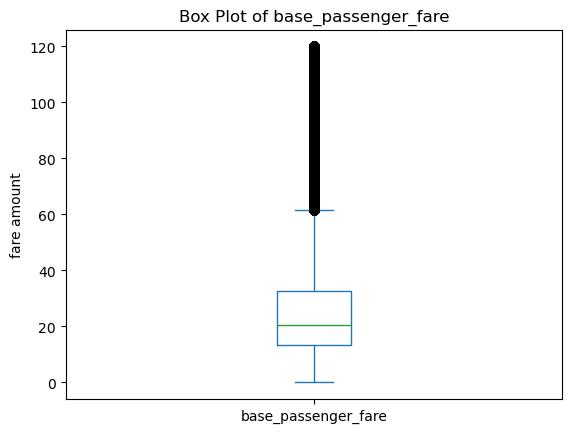

In [43]:
df['base_passenger_fare'].plot.box()
plt.title('Box Plot of base_passenger_fare')
plt.ylabel('fare amount')
plt.show()

To ensure a stable analysis of base_passenger_fare while minimizing distortion from extreme outliers, 
I capped the data at the 99th percentile. This approach retains 99% of real-world trip fares while excluding unusually high

In [45]:
df["base_passenger_fare"].describe()

count   20265893.00
mean          26.34
std           18.82
min            0.01
25%           13.40
50%           20.57
75%           32.61
max          119.99
Name: base_passenger_fare, dtype: float64

In [47]:
df[df["base_passenger_fare"]<1].shape

(421, 14)

In [49]:
df[df["base_passenger_fare"]<1]["trip_time"].mean()           #10 mins

10.045209817893902

In [51]:
df[df["base_passenger_fare"]<1]["trip_miles"].mean()             # 2.8 km

1.7442280285035627

In [182]:
df = df[df["base_passenger_fare"]>1]

In [54]:
df["base_passenger_fare"].describe()

count   20265468.00
mean          26.34
std           18.82
min            1.01
25%           13.40
50%           20.57
75%           32.61
max          119.99
Name: base_passenger_fare, dtype: float64

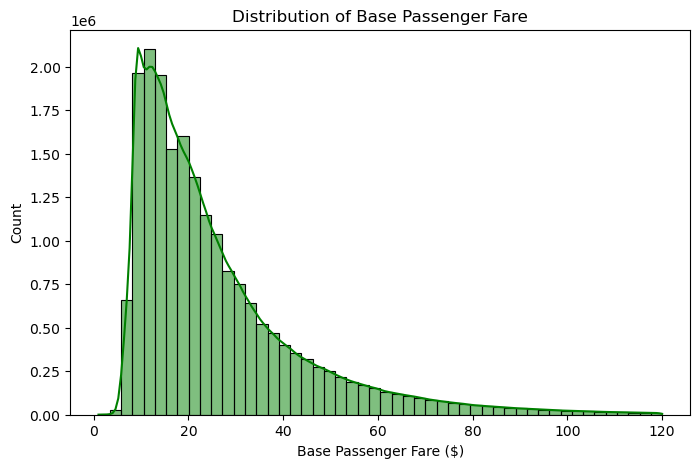

In [368]:
plt.figure(figsize=(8, 5))
sns.histplot(df["base_passenger_fare"], bins=50, kde=True, color='green')
plt.title("Distribution of Base Passenger Fare")
plt.xlabel("Base Passenger Fare ($)")
plt.ylabel("Count")
plt.show()

<h2 align="center" style="color:blue"</h2><h2 align="center" style="color:blue">Exploring Trip Distance </h2>

In [57]:
df[df['trip_miles']==0].shape

(2179, 14)

In [59]:
df = df[df['trip_miles']>0]

In [61]:
df["trip_miles"].describe()

count   20263289.00
mean           4.75
std            4.93
min            0.00
25%            1.51
50%            2.91
75%            6.12
max           92.12
Name: trip_miles, dtype: float64

In [63]:
df["trip_miles"].quantile(0.995) 

26.94

In [65]:
df[df['trip_miles']>26.94].shape

(101203, 14)

In [67]:
(101203/20263714)*100  # it is 0.5%

0.49942967019767454

In [69]:
df = df[df['trip_miles']<26.94]

In [71]:
df[df['trip_miles']<0.06].shape

(2915, 14)

In [73]:
df = df[df['trip_miles']>0.06]

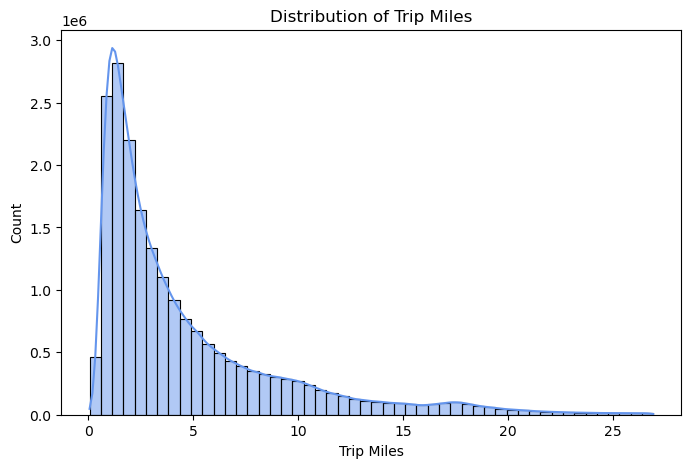

In [370]:
plt.figure(figsize=(8, 5))
sns.histplot(df["trip_miles"], bins=50, kde=True, color='cornflowerblue')
plt.title("Distribution of Trip Miles")
plt.xlabel("Trip Miles")
plt.ylabel("Count")
plt.show()

Trips shorter than 0.06 miles approx 96 meters (about 2,916 records, or 0.014% of the data) were removed 

<h2 align="center" style="color:blue"</h2><h2 align="center" style="color:blue">Exploring Trip Duration </h2>

In [75]:
df["trip_time"].describe()

count   20158751.00
mean          18.59
std           12.37
min            0.12
25%            9.60
50%           15.52
75%           24.27
max          396.77
Name: trip_time, dtype: float64

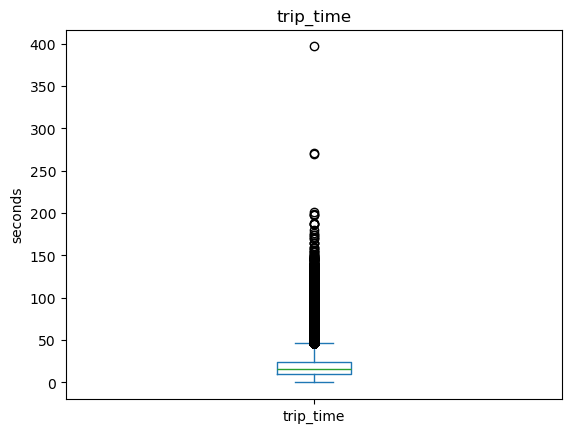

In [77]:
df['trip_time'].plot.box()
plt.title('trip_time')
plt.ylabel('seconds')
plt.show()

In [85]:
df[df["trip_time"]>170].shape

(17, 14)

In [87]:
df = df[df["trip_time"]<170]

Trips with durations exceeding 170 mins (~2.83 hours) were removed to eliminate outliers and improve the reliability of the analysis.

In [89]:
df[df["trip_time"]<2].shape

(25739, 14)

In [91]:
df[df["trip_time"]<2]["trip_miles"].mean()                 # 0.34178670500019426 approx half km

0.34178670500019426

In [93]:
df[df["trip_time"]<2]["base_passenger_fare"].mean()

8.779148374062707

Trips with durations less than 2 minutes were excluded to remove very short or potentially erroneous trips, 
ensuring the analysis focuses on meaningful passenger journeys.

In [95]:
df = df[df["trip_time"]>2]

In [96]:
df["trip_time"].describe()

count   20131921.00
mean          18.61
std           12.37
min            2.02
25%            9.62
50%           15.53
75%           24.28
max          169.77
Name: trip_time, dtype: float64

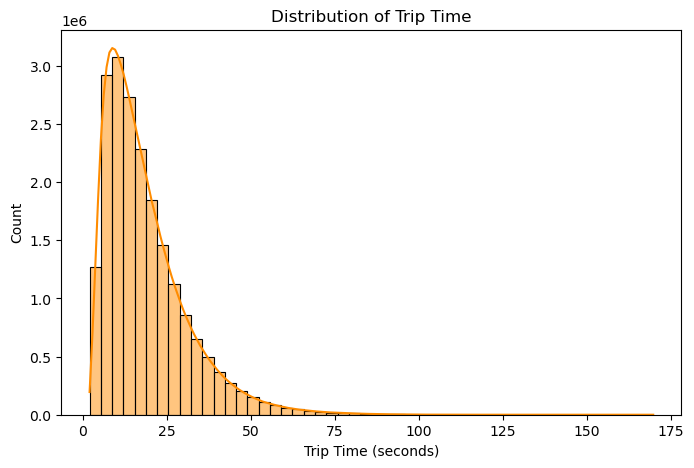

In [99]:
plt.figure(figsize=(8, 5))
sns.histplot(df["trip_time"], bins=50, kde=True, color='darkorange')
plt.title("Distribution of Trip Time")
plt.xlabel("Trip Time (seconds)")
plt.ylabel("Count")
plt.show()

<h1 align="center" style="color:blue">Univariate Analysis of Secondary Attributes</h1>

<h2 align="center" style="color:blue">Toll Trips</h2>

In [211]:
df['tolls'].nunique()

3743

In [213]:
df[df["tolls"]>0].shape

(2606079, 14)

In [215]:
(2606487/20162175)*100     # approx 13% of data

12.927608256549702

In [229]:
df[df['tolls']>0]["tolls"].describe()

count   2606079.00
mean          7.51
std           5.90
min           0.11
25%           3.66
50%           6.94
75%           6.94
max          59.40
Name: tolls, dtype: float64

In [231]:
df[df['tolls']>7].shape

(539869, 14)

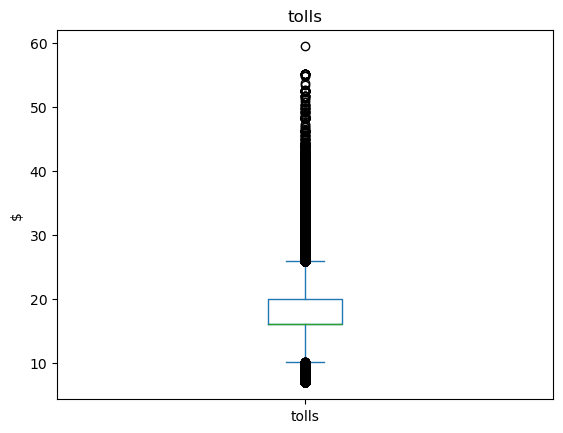

In [237]:
df[df['tolls']>7]["tolls"].plot.box()
plt.title('tolls')
plt.ylabel('$')
plt.show()

In [241]:
df[df['tolls']>55].shape

(10, 14)

<h2 align="center" style="color:blue">Airport Trips</h2>

In [262]:
df["airport_fee"].nunique()

8

In [266]:
df[df["airport_fee"]>0].shape  

(1573650, 21)

In [268]:
(1573650/20162175)*100  # approx 7.8% of data

7.804961518288578

In [243]:
df[df['airport_fee']>0]["airport_fee"].describe()

count   1573450.00
mean          2.50
std           0.21
min           1.00
25%           2.50
50%           2.50
75%           2.50
max           5.00
Name: airport_fee, dtype: float64

<h2 align="center" style="color:blue">Exploring Tips</h2>

In [272]:
df["tips"].nunique()

3768

In [274]:
df[df["tips"]>0].shape  

(3527471, 21)

In [276]:
(3527471/20162175)*100   # approx 17.5% of data

17.495488457966466

In [245]:
df[df['tips']>0]["tips"].describe()

count   3524078.00
mean          5.82
std           4.56
min           0.01
25%           3.00
50%           4.72
75%           7.24
max         100.00
Name: tips, dtype: float64

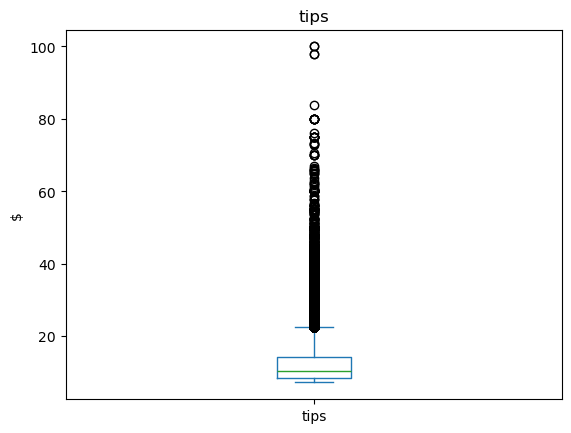

In [251]:
df[df['tips']>7.24]["tips"].plot.box()
plt.title('tips')
plt.ylabel('$')
plt.show()

In [334]:
df[df['tips'] > df['base_passenger_fare']].shape

(4418, 21)

In [346]:
df[df['tips'] > df['base_passenger_fare']]["tips"].mean()

20.14931643277501

While these tips are larger than the base fare, they’re not all extreme in amount. This is actually quite reasonable

<h2 align="center" style="color:blue">Driver Pay</h2>

In [288]:
df["driver_pay"].nunique()

11820

In [290]:
df["driver_pay"].describe()

count   20162175.00
mean          19.18
std           14.10
min          -22.22
25%            8.92
50%           14.97
75%           25.03
max          174.92
Name: driver_pay, dtype: float64

In [294]:
df[df['driver_pay'] < 0].shape

(34, 21)

In [255]:
df = df[df['driver_pay'] > 0]

In [257]:
df["driver_pay"].describe()

count   20129201.00
mean          19.20
std           14.10
min            0.01
25%            8.95
50%           15.00
75%           25.06
max          174.92
Name: driver_pay, dtype: float64

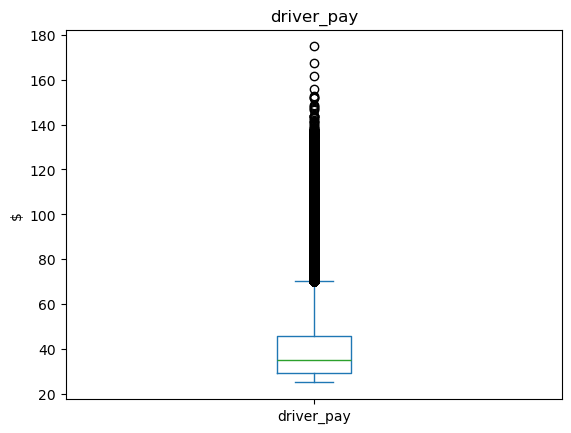

In [259]:
df[df['driver_pay']>25.06]["driver_pay"].plot.box()
plt.title('driver_pay')
plt.ylabel('$')
plt.show()

<h2 align="center" style="color:blue">Congestion Column</h2>

In [209]:
df["total_congestion"].describe()

count   20131918.00
mean           1.50
std            1.96
min            0.00
25%            0.00
50%            0.00
75%            4.25
max            4.25
Name: total_congestion, dtype: float64

In [415]:
df[df["total_congestion"]>0].shape

(7922071, 15)

In [261]:
(7922071/20131918)*100

39.35080105134543

In [263]:
df[df["total_congestion"]>0]["total_congestion"].describe()

count   7738098.00
mean          3.91
std           0.78
min           0.75
25%           4.25
50%           4.25
75%           4.25
max           4.25
Name: total_congestion, dtype: float64

<h2 align="center" style="color:blue">Correcting Datetime Columns</h2>

In [111]:
df[["request_datetime","pickup_datetime","dropoff_datetime"]].describe()

,request_datetime,pickup_datetime,dropoff_datetime
count,20131921,20131921,20131921
mean,2025-03-16 07:50:48.514579,2025-03-16 07:55:29.603490,2025-03-16 08:14:06.289814
min,2025-02-28 22:07:00,2025-03-01 00:00:00,2025-03-01 00:02:19
25%,2025-03-08 12:57:05,2025-03-08 13:00:55,2025-03-08 13:18:41
50%,2025-03-16 00:01:49,2025-03-16 00:07:51,2025-03-16 00:26:26
75%,2025-03-23 20:14:55,2025-03-23 20:21:22,2025-03-23 20:38:29
max,2025-03-31 23:58:39,2025-03-31 23:59:58,2025-04-01 00:59:33


#### Check for pre-bookings

In [114]:
df[df['request_datetime'] < df['pickup_datetime']].shape

(19923813, 14)

In [116]:
(19923813/20131921)*100

98.96627847883966

#### Checking records whose pickup and dropoff location same

In [122]:
df[df["PULocationID"] == df["DOLocationID"]].shape

(1528346, 14)

In [146]:
(1528346/20131921)*100

7.591655063617625

Almost 7.6 % of total trips are round trips

#### Checking did all Drop-offs happen after pickups:

In [131]:
df[df['dropoff_datetime'] < df['pickup_datetime']].shape

(0, 14)

#### Checking for instant bookings

In [134]:
df[df['request_datetime'] == df['pickup_datetime']].shape   

(205, 14)

#### Removing Time zone inconsistencies

In [137]:
df[df['request_datetime'] > df['pickup_datetime']].shape   # approximately 1%

(207903, 14)

In [139]:
(207903/20131921)*100

1.0327032378082548

Filtering due to data quality issues 

In [142]:
df = df[df['request_datetime'] <= df['pickup_datetime']]